In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"royaldennishayford","key":"9f412ffc8c120990742f3737b5a7338a"}'}

In [5]:
import os

# Create .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Move kaggle.json to the .kaggle directory
# Assuming the user has uploaded kaggle.json to /content/
if os.path.exists('/content/kaggle.json'):
    !mv /content/kaggle.json ~/.kaggle/
    # Set permissions for kaggle.json
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle API key configured successfully.")
else:
    print("kaggle.json not found in /content/. Please upload it first.")

# Verify configuration (optional)
!ls -l ~/.kaggle

kaggle.json not found in /content/. Please upload it first.
total 4
-rw------- 1 root root 74 Dec 10 01:28 kaggle.json


In [7]:
import os

# Define the dataset and destination path
dataset_name = "kmader/skin-cancer-mnist-ham10000"
destination_path = "/content/"

# Download the dataset
print(f"Downloading dataset: {dataset_name} to {destination_path}")
!kaggle datasets download -d {dataset_name} -p {destination_path} --unzip

print("Dataset downloaded and unzipped successfully.")

# Verify the contents of the /content/ directory
!ls -l /content/

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
skin-cancer-mnist-ham10000.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset downloaded and unzipped successfully.
total 5452112
drwxr-xr-x 2 root root      36864 Dec 10 01:33 HAM10000_images_part_1
drwxr-xr-x 1 root root       4096 Nov 20 14:30 sample_data
-rw-r--r-- 1 root root 5582914511 Oct  6  2019 skin-cancer-mnist-ham10000.zip


In [42]:
#Import Libraries and set
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, monotonically_increasing_id, rand
from pyspark.sql import functions as F

from sklearn.metrics import (roc_auc_score, average_precision_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, ConfusionMatrixDisplay)
from sklearn.utils import class_weight

import cv2

BASE_DIR = "/content"
META_PATH = os.path.join(BASE_DIR, "HAM10000_metadata.csv")
SPLIT_DIR = os.path.join(BASE_DIR, "outputs", "splits")
MODEL_DIR = os.path.join(BASE_DIR, "model_outputs")

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(SPLIT_DIR, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS_HEAD = 5
EPOCHS_FINE = 5

In [13]:
#Preprocessing with Spark
import os
import glob
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, monotonically_increasing_id, rand
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType
import pandas as pd

def run_preprocessing():
    print("\n" + "="*70)
    print("STEP 1: PREPROCESSING WITH SPARK (TRAIN/VAL/TEST SPLITS)")
    print("="*70)

    spark = (
        SparkSession.builder
        .appName("HAM10000_SkinLesion_Splits")
        .getOrCreate()
    )

    # 1. Read metadata
    df_meta = (
        spark.read.option("header", True)
        .option("inferSchema", True)
        .csv(f"file://{META_PATH}")
    )

    # Binary label: 1 = melanoma, 0 = non-melanoma
    df_meta = df_meta.withColumn(
        "label_int",
        F.when(F.col("dx") == "mel", 1).otherwise(0)
    )

    # Map image_id to actual image paths
    print("[INFO] Building image_id to filepath mapping...")
    all_image_files = []
    # Ensure all possible directory names are covered
    image_source_dirs = [
        "HAM10000_images_part_1", "HAM10000_images_part_2",
        "ham10000_images_part_1", "ham10000_images_part_2"
    ]
    for img_dir_name in image_source_dirs:
        full_path_dir = os.path.join(BASE_DIR, img_dir_name)
        if os.path.isdir(full_path_dir):
            all_image_files.extend(glob.glob(os.path.join(full_path_dir, "*.jpg")))

    # Create a Python dictionary mapping image_id to full path
    image_id_to_full_path = {os.path.basename(f).replace(".jpg", ""): f for f in all_image_files}

    # Convert this dictionary to a Spark DataFrame
    schema = StructType([
        StructField("image_id", StringType(), True),
        StructField("filepath", StringType(), True)
    ])
    image_paths_data = [(img_id, path) for img_id, path in image_id_to_full_path.items()]
    image_paths_df = spark.createDataFrame(image_paths_data, schema=schema)

    # Join the metadata DataFrame with the image paths DataFrame
    df_paths = df_meta.join(image_paths_df, on="image_id", how="left")

    # Filter out any metadata entries that don't have a corresponding image file
    initial_count = df_paths.count()
    df_paths = df_paths.filter(F.col("filepath").isNotNull())
    if df_paths.count() < initial_count:
        print(f"[WARNING] Removed {initial_count - df_paths.count()} entries due to missing image files.")

    # Use lesion_id as patient_id for splitting
    df_paths = df_paths.withColumnRenamed("lesion_id", "patient_id")

    patients = (
        df_paths.select("patient_id")
        .distinct()
        .orderBy(rand())
        .withColumn("idx", monotonically_increasing_id())
    )

    total_patients = patients.count()
    train_cut = int(total_patients * 0.70)
    val_cut   = int(total_patients * 0.85)

    patients = patients.withColumn(
        "split",
        F.when(col("idx") < train_cut, "train")
         .when(col("idx") < val_cut, "val")
         .otherwise("test")
    ).drop("idx")

    df_split = df_paths.join(patients, on="patient_id", how="inner")

    # 4. Save CSVs under SPLIT_DIR
    (df_split.filter(col("split") == "train")
        .select("filepath", "label_int")
        .coalesce(1)
        .write.mode("overwrite").option("header", True)
        .csv(os.path.join(SPLIT_DIR, "train")))

    (df_split.filter(col("split") == "val")
        .select("filepath", "label_int")
        .coalesce(1)
        .write.mode("overwrite").option("header", True)
        .csv(os.path.join(SPLIT_DIR, "val")))

    (df_split.filter(col("split") == "test")
        .select("filepath", "label_int")
        .coalesce(1)
        .write.mode("overwrite").option("header", True)
        .csv(os.path.join(SPLIT_DIR, "test")))

    spark.stop()
    print("[DONE] Train/val/test CSVs written to:", SPLIT_DIR)


run_preprocessing()


STEP 1: PREPROCESSING WITH SPARK (TRAIN/VAL/TEST SPLITS)
[INFO] Building image_id to filepath mapping...
[DONE] Train/val/test CSVs written to: /content/outputs/splits


In [14]:
# Model Training

def find_split_csv(split_name):
    folder = os.path.join(SPLIT_DIR, split_name)
    files = glob.glob(os.path.join(folder, "part-*.csv"))
    if not files:
        raise FileNotFoundError(f"No part-*.csv found in {folder}")
    return files[0]


def load_split(split_name):
    csv_path = find_split_csv(split_name)
    df = pd.read_csv(csv_path)

    def fix_path(p):
        if p.startswith("/"):
            return p
        fname = os.path.basename(p)
        return os.path.join(BASE_DIR, fname)

    df["filepath"] = df["filepath"].apply(fix_path)

    filepaths = df["filepath"].values
    labels = df["label_int"].astype("float32").values
    return filepaths, labels


def decode_img(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, IMG_SIZE)
    return img, label


def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, label


def make_dataset(filepaths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(filepaths), reshuffle_each_iteration=True)
    ds = ds.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


def build_resnet_model():
    """
    TRANSFER LEARNING using ResNet50 pre-trained on ImageNet.
    We:
      - load ResNet50 with weights='imagenet', no top
      - freeze it first (feature extractor)
      - add our own classification head for melanoma (binary)
    """
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    base_model.trainable = False  # freeze for first phase

    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs, name="melanoma_resnet50")
    return model, base_model


def run_training():
    print("\n" + "="*70)
    print("STEP 2: TRAINING RESNET50 (TRANSFER LEARNING)")
    print("="*70)

    # Load data
    train_files, train_labels = load_split("train")
    val_files,   val_labels   = load_split("val")
    test_files,  test_labels  = load_split("test")

    print(f"Train samples: {len(train_files)}")
    print(f"Val samples:   {len(val_files)}")
    print(f"Test samples:  {len(test_files)}")

    train_ds = make_dataset(train_files, train_labels, training=True)
    val_ds   = make_dataset(val_files,   val_labels,   training=False)
    test_ds  = make_dataset(test_files,  test_labels,  training=False)

    # Class weights
    class_weights_vals = class_weight.compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = {i: w for i, w in enumerate(class_weights_vals)}
    print("Class weights:", class_weights)

    # ---- BUILD RESNET50 TRANSFER LEARNING MODEL ----
    model, base_model = build_resnet_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auroc"),
            tf.keras.metrics.AUC(name="auprc", curve="PR"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )

    model.summary()

    checkpoint_path = os.path.join(MODEL_DIR, "best_model_head.h5")
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor="val_auroc",
        mode="max",
        save_best_only=True,
        verbose=1,
    )

    early_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_auroc",
        mode="max",
        patience=3,
        restore_best_weights=True,
        verbose=1,
    )

    # Phase 1: train classifier head
    print("\n==== Phase 1: train frozen ResNet50 + new head ====\n")
    history_head = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_HEAD,
        callbacks=[checkpoint_cb, early_cb],
        class_weight=class_weights,
    )

    # Phase 2: fine-tune last ResNet layers (classic transfer learning step)
    print("\n==== Phase 2: fine-tune last layers of ResNet50 ====\n")
    fine_tune_at = len(base_model.layers) - 40  # unfreeze last ~40 layers
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auroc"),
            tf.keras.metrics.AUC(name="auprc", curve="PR"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
        ],
    )

    checkpoint_path_fine = os.path.join(MODEL_DIR, "best_model_finetuned.h5")
    checkpoint_cb_fine = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path_fine,
        monitor="val_auroc",
        mode="max",
        save_best_only=True,
        verbose=1,
    )

    history_fine = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_FINE,
        callbacks=[checkpoint_cb_fine, early_cb],
        class_weight=class_weights,
    )

    # Save final model
    final_model_path = os.path.join(MODEL_DIR, "melanoma_resnet50_final.keras")
    model.save(final_model_path)
    print(f"\nSaved final model to: {final_model_path}")

    # Quick test evaluation
    print("\n==== Quick Evaluation on test set (threshold=0.5) ====\n")
    y_prob = model.predict(test_ds).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    cm = confusion_matrix(test_labels, y_pred)
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n",
          classification_report(test_labels, y_pred, digits=4))

    metrics_path = os.path.join(MODEL_DIR, "test_metrics_quick.txt")
    with open(metrics_path, "w") as f:
        f.write("Confusion Matrix:\n")
        f.write(str(cm) + "\n\n")
        f.write("Classification Report:\n")
        f.write(classification_report(test_labels, y_pred, digits=4))

    print(f"\n[Saved] Quick metrics to: {metrics_path}")

run_training()



STEP 2: TRAINING RESNET50 (TRANSFER LEARNING)
Train samples: 7011
Val samples:   1518
Test samples:  1486
Class weights: {0: np.float64(0.5644927536231884), 1: np.float64(4.376404494382022)}


Model: "melanoma_resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    524,544 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        257 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


==== Phase 1: train frozen ResNet50 + new head ====

Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6003 - auprc: 0.1172 - auroc: 0.5024 - loss: 0.9527 - precision: 0.1262 - recall: 0.3843
Epoch 1: val_auroc improved from -inf to 0.66263, saving model to /content/model_outputs/best_model_head.h5


439/439 ━━━━━━━━━━━━━━━━━━━━ 97s 179ms/step - accuracy: 0.6001 - auprc: 0.1172 - auroc: 0.5024 - loss: 0.9524 - precision: 0.1262 - recall: 0.3845 - val_accuracy: 0.1126 - val_auprc: 0.1561 - val_auroc: 0.6626 - val_loss: 0.7013 - val_precision: 0.1033 - val_recall: 0.9936
Epoch 2/5
438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.4838 - auprc: 0.1217 - auroc: 0.4991 - loss: 0.7951 - precision: 0.1211 - recall: 0.5316
Epoch 2: val_auroc did not improve from 0.66263
439/439 ━━━━━━━━━━━━━━━━━━━━ 53s 122ms/step - accuracy: 0.4838 - auprc: 0.1217 - auroc: 0.4992 - loss: 0.7949 - precision: 0.1211 - recall: 0.5316 - val_accuracy: 0.1028 - val_auprc: 0.1441 - val_auroc: 0.6273 - val_loss: 0.7890 - val_precision: 0.1028 - val_recall: 1.0000
Epoch 3/5
438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5066 - auprc: 0.1141 - auroc: 0.5028 - loss: 0.7581 - precision: 0.1132 - recall: 0.4732
Epoch 3: val_auroc did not improve from 0.66263
439/439 ━━━━━━━━━━━━━━━━━━━━ 55s 124ms/step 

439/439 ━━━━━━━━━━━━━━━━━━━━ 105s 174ms/step - accuracy: 0.6014 - auprc: 0.1727 - auroc: 0.6197 - loss: 0.6823 - precision: 0.1590 - recall: 0.5702 - val_accuracy: 0.7036 - val_auprc: 0.3181 - val_auroc: 0.8111 - val_loss: 0.4933 - val_precision: 0.2195 - val_recall: 0.7372
Epoch 2/5
438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6566 - auprc: 0.2283 - auroc: 0.7520 - loss: 0.5658 - precision: 0.1989 - recall: 0.7281
Epoch 2: val_auroc did not improve from 0.81111
439/439 ━━━━━━━━━━━━━━━━━━━━ 57s 130ms/step - accuracy: 0.6565 - auprc: 0.2284 - auroc: 0.7520 - loss: 0.5659 - precision: 0.1990 - recall: 0.7283 - val_accuracy: 0.7372 - val_auprc: 0.2985 - val_auroc: 0.7949 - val_loss: 0.4443 - val_precision: 0.2270 - val_recall: 0.6474
Epoch 3/5
438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6519 - auprc: 0.2526 - auroc: 0.7587 - loss: 0.5694 - precision: 0.2058 - recall: 0.7402
Epoch 3: val_auroc did not improve from 0.81111
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step

439/439 ━━━━━━━━━━━━━━━━━━━━ 57s 130ms/step - accuracy: 0.6590 - auprc: 0.2831 - auroc: 0.7909 - loss: 0.5328 - precision: 0.2230 - recall: 0.8029 - val_accuracy: 0.3175 - val_auprc: 0.3175 - val_auroc: 0.8208 - val_loss: 0.8847 - val_precision: 0.1309 - val_recall: 1.0000
Epoch 5/5
438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6344 - auprc: 0.2966 - auroc: 0.7873 - loss: 0.5384 - precision: 0.2194 - recall: 0.8297
Epoch 5: val_auroc did not improve from 0.82078
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 127ms/step - accuracy: 0.6345 - auprc: 0.2966 - auroc: 0.7873 - loss: 0.5384 - precision: 0.2194 - recall: 0.8297 - val_accuracy: 0.8017 - val_auprc: 0.3036 - val_auroc: 0.8012 - val_loss: 0.3525 - val_precision: 0.2698 - val_recall: 0.5449
Restoring model weights from the end of the best epoch: 4.

Saved final model to: /content/model_outputs/melanoma_resnet50_final.keras

==== Quick Evaluation on test set (threshold=0.5) ====

93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step
Confusion Matr


STEP 3: DETAILED TEST EVALUATION (ROC/PR/CM, metrics)
[DEBUG] Using test CSV: /content/outputs/splits/test/part-00000-9c5c2323-1f3e-4df7-b75d-603a6497f377-c000.csv
[INFO] Test set size: 1486
[INFO] Class distribution: [1330  156]
[INFO] Loading model from /content/model_outputs/melanoma_resnet50_final.keras

[INFO] Running predictions on test set...
93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step

TEST SET RESULTS (threshold = 0.50)
Accuracy:     0.3392
AUROC:        0.8152
AUPRC:        0.3326
Sensitivity:  0.9936
Specificity:  0.2624
PPV (Prec):   0.1364
NPV:          0.9971

Confusion matrix (threshold=0.5):
[[349 981]
 [  1 155]]

Classification report (threshold=0.5):
              precision    recall  f1-score   support

         0.0      0.997     0.262     0.415      1330
         1.0      0.136     0.994     0.240       156

    accuracy                          0.339      1486
   macro avg      0.567     0.628     0.328      1486
weighted avg      0.907     0.339     0.397      14

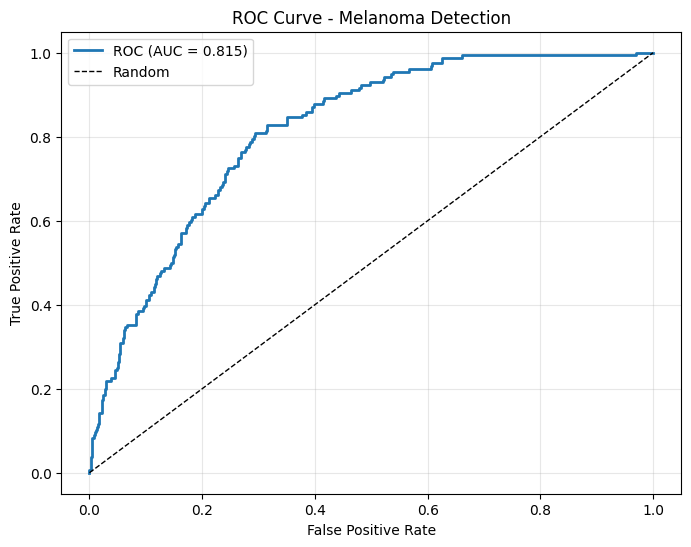

[SAVED] ROC curve: /content/model_outputs/roc_curve.png
[DEBUG] Entering plot_pr_curve


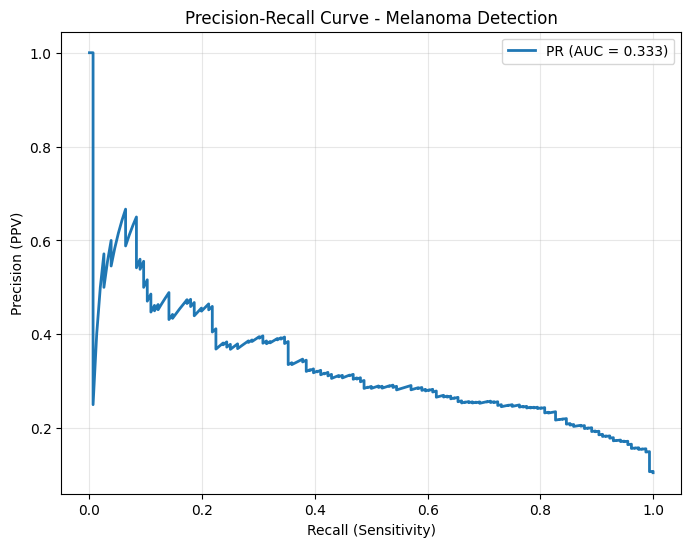

[SAVED] PR curve: /content/model_outputs/pr_curve.png


<Figure size 600x600 with 0 Axes>

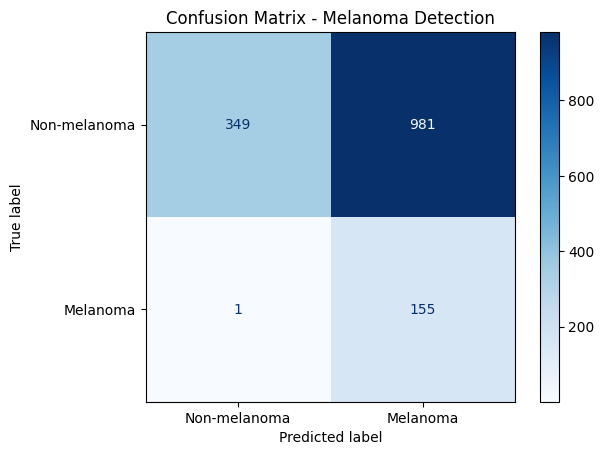

[SAVED] Confusion matrix image: /content/model_outputs/confusion_matrix_thr05.png

TEST SET RESULTS (optimal threshold = 0.6747, Youden's J)
Accuracy:     0.7167
Sensitivity:  0.8077
Specificity:  0.7060
PPV (Prec):   0.2437
NPV:          0.9690

Confusion matrix (optimal threshold):
[[939 391]
 [ 30 126]]

Classification report (optimal threshold):
              precision    recall  f1-score   support

         0.0      0.969     0.706     0.817      1330
         1.0      0.244     0.808     0.374       156

    accuracy                          0.717      1486
   macro avg      0.606     0.757     0.596      1486
weighted avg      0.893     0.717     0.770      1486



<Figure size 600x600 with 0 Axes>

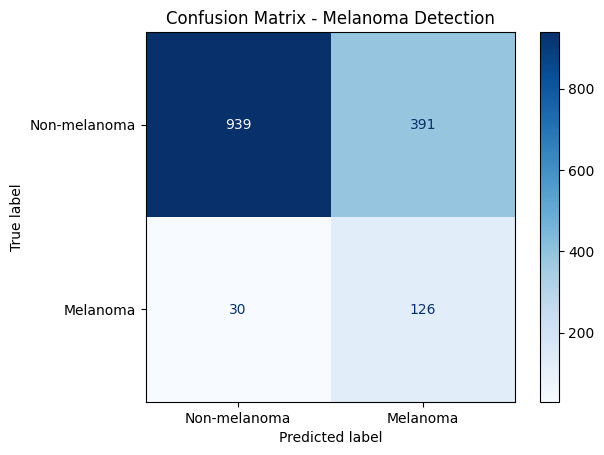

[SAVED] Confusion matrix image: /content/model_outputs/confusion_matrix_optimal.png

DETAILED EVALUATION COMPLETE!


In [44]:
# Model Evaluation

def run_detailed_evaluation():
    print("\n" + "="*70)
    print("STEP 3: DETAILED TEST EVALUATION (ROC/PR/CM, metrics)")
    print("="*70)

    # ---- Load test CSV ----
    test_folder = os.path.join(SPLIT_DIR, "test")
    csv_path_list = glob.glob(os.path.join(test_folder, "part-*.csv"))
    if not csv_path_list:
        raise FileNotFoundError(f"No part-*.csv found in {test_folder}")
    csv_path = csv_path_list[0]
    print("[DEBUG] Using test CSV:", csv_path)

    df = pd.read_csv(csv_path)

    def fix_path_eval(p):
        if p.startswith("/"):
            return p
        return os.path.join(BASE_DIR, os.path.basename(p))

    df["filepath"] = df["filepath"].apply(fix_path_eval)

    paths = df["filepath"].values
    labels = df["label_int"].values.astype("float32")

    print(f"[INFO] Test set size: {len(labels)}")
    print(f"[INFO] Class distribution: {np.bincount(labels.astype(int))}")

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(preprocess_image_eval, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # ---- Load model and predict ----
    model = load_model_for_eval()
    print("\n[INFO] Running predictions on test set...")
    probs = model.predict(ds).ravel()

    y_true = labels

    # ========== PART 1: Threshold = 0.5 ==========
    thr_default = 0.5
    y_pred_05 = (probs >= thr_default).astype("int32")

    acc_05 = (y_pred_05 == y_true).mean()
    auroc = roc_auc_score(y_true, probs)
    auprc = average_precision_score(y_true, probs)

    cm_05 = confusion_matrix(y_true, y_pred_05)
    clinical_05 = compute_clinical_metrics(cm_05)
    report_05 = classification_report(y_true, y_pred_05, digits=3)

    print("\n" + "="*70)
    print(f"TEST SET RESULTS (threshold = {thr_default:.2f})")
    print("="*70)
    print(f"Accuracy:     {acc_05:.4f}")
    print(f"AUROC:        {auroc:.4f}")
    print(f"AUPRC:        {auprc:.4f}")
    print(f"Sensitivity:  {clinical_05['sensitivity']:.4f}")
    print(f"Specificity:  {clinical_05['specificity']:.4f}")
    print(f"PPV (Prec):   {clinical_05['ppv']:.4f}")
    print(f"NPV:          {clinical_05['npv']:.4f}")

    print("\nConfusion matrix (threshold=0.5):")
    print(cm_05)
    print("\nClassification report (threshold=0.5):")
    print(report_05)

    # ---- Plots: ROC, PR, Confusion Matrix for thr=0.5 ----
    roc_path = os.path.join(MODEL_DIR, "roc_curve.png")
    pr_path  = os.path.join(MODEL_DIR, "pr_curve.png")
    cm_path  = os.path.join(MODEL_DIR, "confusion_matrix_thr05.png")

    plot_roc_curve(y_true, probs, roc_path)
    plot_pr_curve(y_true, probs, pr_path)
    plot_confusion_matrix_image(y_true, y_pred_05, cm_path)

    # ========== PART 2: Optimal threshold (Youden's J) ==========
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_thr = thresholds[best_idx]

    y_pred_best = (probs >= best_thr).astype("int32")
    acc_best = (y_pred_best == y_true).mean()
    cm_best = confusion_matrix(y_true, y_pred_best)
    clinical_best = compute_clinical_metrics(cm_best)
    report_best = classification_report(y_true, y_pred_best, digits=3)

    print("\n" + "="*70)
    print(f"TEST SET RESULTS (optimal threshold = {best_thr:.4f}, Youden's J)")
    print("="*70)
    print(f"Accuracy:     {acc_best:.4f}")
    print(f"Sensitivity:  {clinical_best['sensitivity']:.4f}")
    print(f"Specificity:  {clinical_best['specificity']:.4f}")
    print(f"PPV (Prec):   {clinical_best['ppv']:.4f}")
    print(f"NPV:          {clinical_best['npv']:.4f}")

    print("\nConfusion matrix (optimal threshold):")
    print(cm_best)
    print("\nClassification report (optimal threshold):")
    print(report_best)

    cm_best_path = os.path.join(MODEL_DIR, "confusion_matrix_optimal.png")
    plot_confusion_matrix_image(y_true, y_pred_best, cm_best_path)

    print("\n" + "="*70)
    print("DETAILED EVALUATION COMPLETE!")
    print("="*70)

run_detailed_evaluation()

In [39]:
GRADCAM_DIR = os.path.join(MODEL_DIR, "gradcam")
os.makedirs(GRADCAM_DIR, exist_ok=True)


def load_model_for_gradcam():
    keras_path = os.path.join(MODEL_DIR, "melanoma_resnet50_final.keras")
    if os.path.exists(keras_path):
        print(f"[INFO] Loading full model from: {keras_path}")
        return tf.keras.models.load_model(keras_path, compile=False)

    weights_path = os.path.join(MODEL_DIR, "best_model_finetuned.h5")
    print(f"[INFO] Restoring model weights from: {weights_path}")

    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Missing model weight file: {weights_path}")

    # Rebuild same architecture as training
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    )
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs, name="melanoma_resnet50")
    model.load_weights(weights_path)
    return model


def preprocess_image_gradcam(path):
    raw = tf.io.read_file(path)
    img = tf.io.decode_jpeg(raw, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, IMG_SIZE)
    return img


def find_last_conv_layer(model):
    """
    Find the last 4D (H, W, C) layer that is NOT a sub-model.
    """
    for layer in reversed(model.layers):
        # Skip submodels (like the ResNet50 wrapper itself)
        if isinstance(layer, tf.keras.Model):
            continue
        try:
            shape = layer.output.shape
        except AttributeError:
            continue
        if len(shape) == 4:
            print(f"[INFO] Using last conv layer: {layer.name}, shape={shape}")
            return layer
    raise ValueError("No convolutional layer found in model.")


def make_gradcam_heatmap(img_array, model):
    """
    Robust Grad-CAM:
    - automatically finds the last conv layer
    - builds a small grad_model from that
    """
    last_conv_layer = find_last_conv_layer(model)

    # Model that maps input -> (conv feature maps, predictions)
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [last_conv_layer.output, model.output],
        name="gradcam_model"
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)

    if grads is None:
        print("[ERROR] Gradients are None!")
        return np.zeros((7, 7))

    # Global average pooling over H,W for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[0]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)

    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()

    print(f"  [INFO] Heatmap range: [{heatmap.min():.3f}, {heatmap.max():.3f}]")
    return heatmap


def overlay_heatmap(heatmap, img, alpha=0.4):
    if heatmap.shape != IMG_SIZE:
        heatmap_resized = cv2.resize(heatmap, IMG_SIZE, interpolation=cv2.INTER_CUBIC)
    else:
        heatmap_resized = heatmap

    heatmap_uint8 = np.uint8(255 * heatmap_resized)

    import matplotlib.cm as cm
    colormap_fn = cm.get_cmap('jet')
    heatmap_colored = colormap_fn(heatmap_uint8)[:, :, :3]
    heatmap_colored = (heatmap_colored * 255).astype(np.uint8)

    img_uint8 = (img.numpy() * 255).astype(np.uint8)
    overlay = (img_uint8 * (1 - alpha) + heatmap_colored * alpha).astype(np.uint8)

    return overlay, heatmap_resized


def save_visualization(original_img, heatmap, overlay, save_path, label, pred_prob, method="GradCAM"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    im = axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title(f'{method} Heatmap')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)

    axes[2].imshow(overlay)
    pred_class = "Malignant" if pred_prob > 0.5 else "Benign"
    axes[2].set_title(f'True: {label.capitalize()}\nPred: {pred_class} ({pred_prob:.2%})')
    axes[2].axis('off')

    plt.tight_layout()

    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()


def run_gradcam():
    print("\n" + "="*70)
    print("STEP 4: GRAD-CAM VISUALIZATIONS")
    print("="*70)

    model = load_model_for_gradcam()

    # Load test split
    test_folder = os.path.join(SPLIT_DIR, "test")
    csv_path = glob.glob(os.path.join(test_folder, "part-*.csv"))[0]
    df = pd.read_csv(csv_path)

    def fix_path_gc(p):
        if p.startswith("/"):
            return p
        fname = os.path.basename(p)
        return os.path.join(BASE_DIR, fname)

    df["filepath"] = df["filepath"].apply(fix_path_gc)
    df = df[df["filepath"].apply(os.path.exists)]
    print(f"[INFO] Found {len(df)} valid test images")

    # pick a few positive and negative samples
    mel = df[df["label_int"] == 1].head(3)
    ben = df[df["label_int"] == 0].head(3)
    samples = [("melanoma", r["filepath"]) for _, r in mel.iterrows()] + \
              [("benign", r["filepath"]) for _, r in ben.iterrows()]


    for idx, (cls, path) in enumerate(samples, 1):
        print(f"\n[{idx}/{len(samples)}] {os.path.basename(path)} ({cls})")
        img = preprocess_image_gradcam(path)
        img_batch = tf.expand_dims(img, 0)

        pred_prob = model.predict(img_batch, verbose=0)[0, 0]

        heatmap = make_gradcam_heatmap(img_batch, model)
        overlay, heatmap_resized = overlay_heatmap(heatmap, img)

        save_path = os.path.join(
            GRADCAM_DIR,
            f"{cls}_gradcam_{os.path.basename(path).replace('.jpg', '.png')}"
        )
        save_visualization(
            (img.numpy() * 255).astype(np.uint8),
            heatmap_resized,
            overlay,
            save_path,
            cls,
            pred_prob,
            method="Grad-CAM"
        )


STEP 4: GRAD-CAM VISUALIZATIONS
[INFO] Loading full model from: /content/model_outputs/melanoma_resnet50_final.keras
[INFO] Found 1486 valid test images

[1/6] ISIC_0031890.jpg (melanoma)
[INFO] Using last conv layer: input_layer_3, shape=(None, 224, 224, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_3']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


[ERROR] Gradients are None!


/tmp/ipython-input-3061910223.py:116: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap_fn = cm.get_cmap('jet')


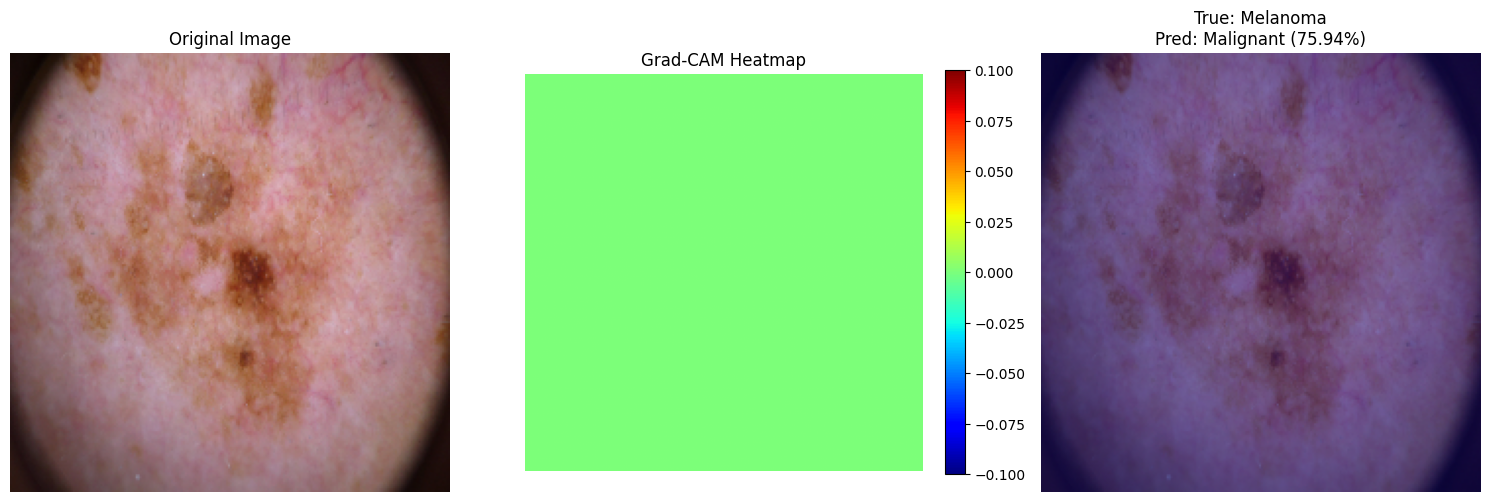


[2/6] ISIC_0032630.jpg (melanoma)
[INFO] Using last conv layer: input_layer_3, shape=(None, 224, 224, 3)
[ERROR] Gradients are None!


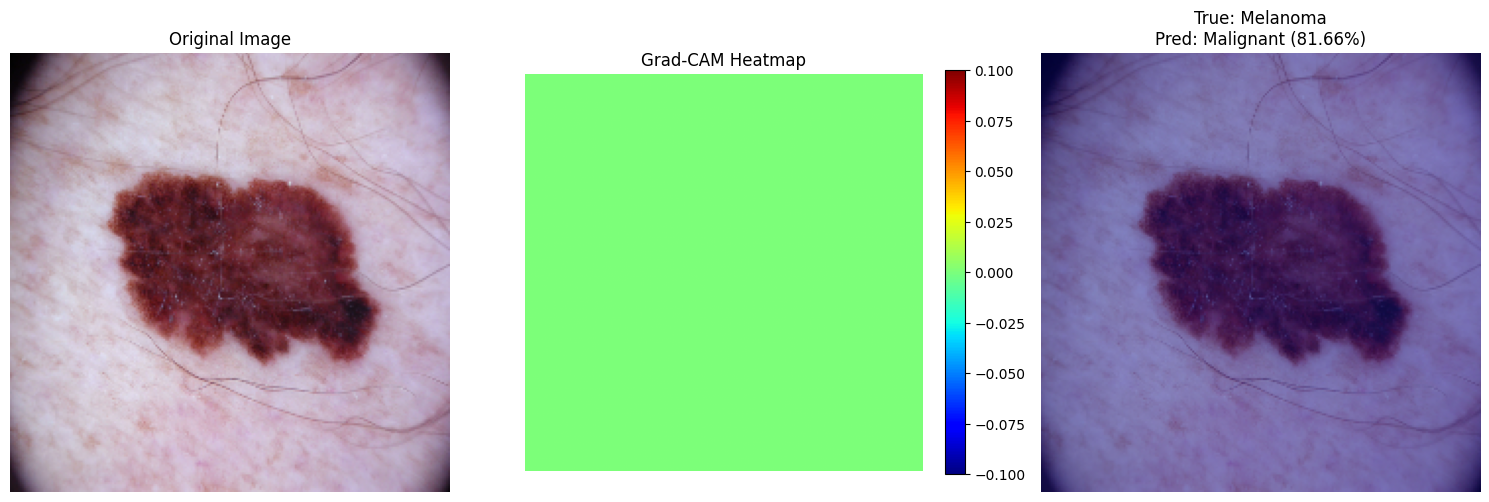


[3/6] ISIC_0033399.jpg (melanoma)
[INFO] Using last conv layer: input_layer_3, shape=(None, 224, 224, 3)
[ERROR] Gradients are None!


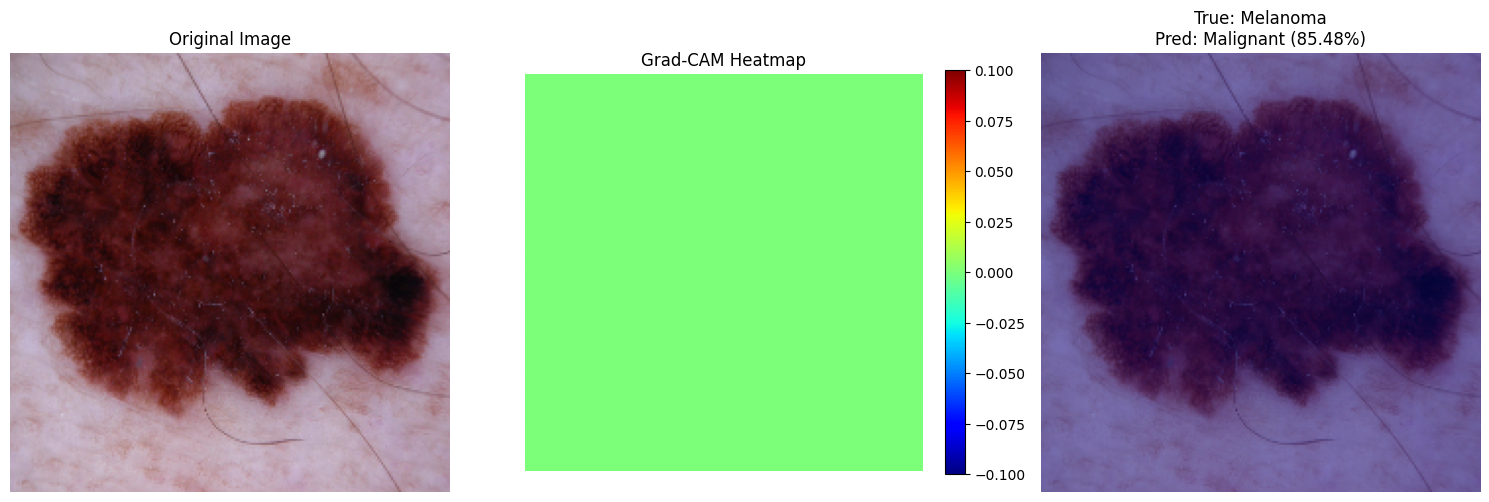


[4/6] ISIC_0027748.jpg (benign)
[INFO] Using last conv layer: input_layer_3, shape=(None, 224, 224, 3)
[ERROR] Gradients are None!


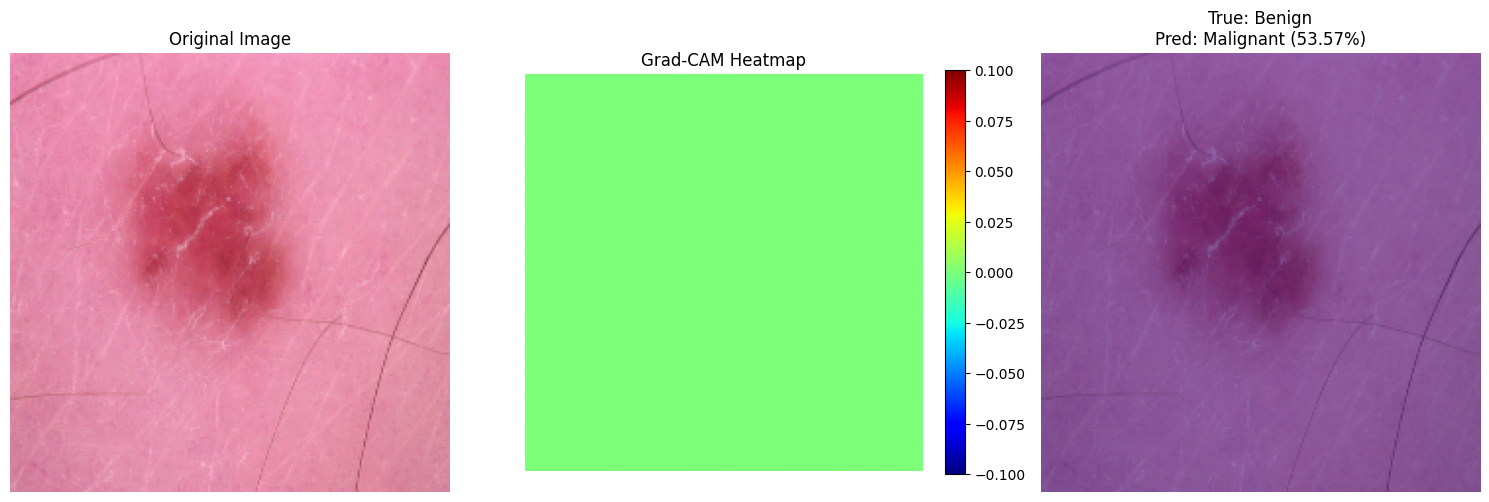


[5/6] ISIC_0027842.jpg (benign)
[INFO] Using last conv layer: input_layer_3, shape=(None, 224, 224, 3)
[ERROR] Gradients are None!


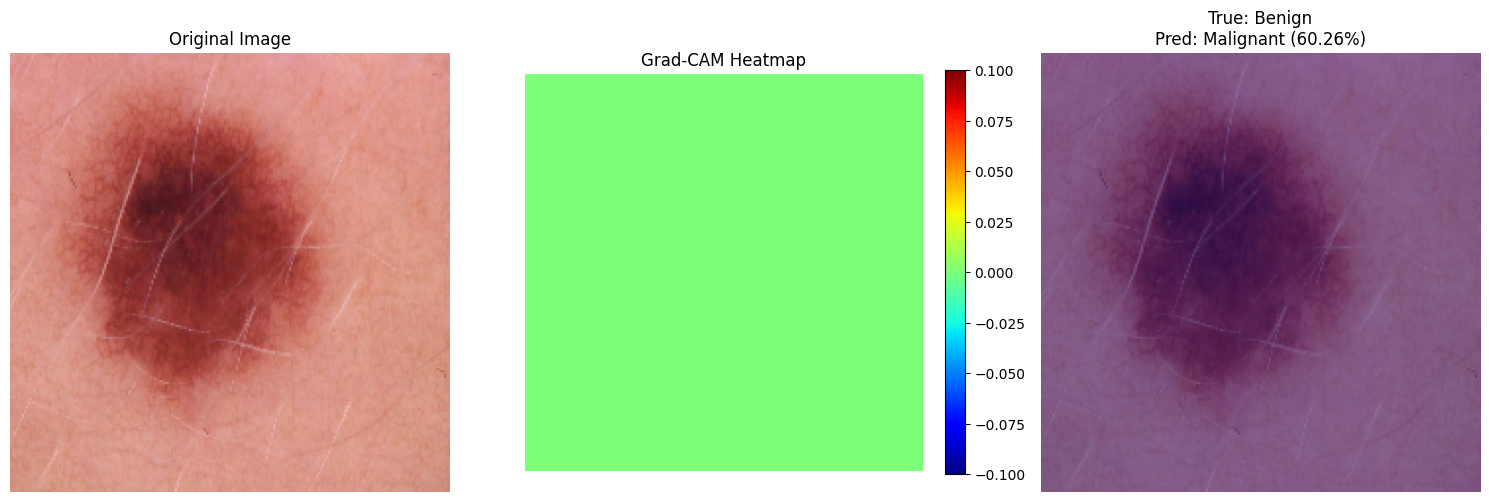


[6/6] ISIC_0032176.jpg (benign)
[INFO] Using last conv layer: input_layer_3, shape=(None, 224, 224, 3)
[ERROR] Gradients are None!


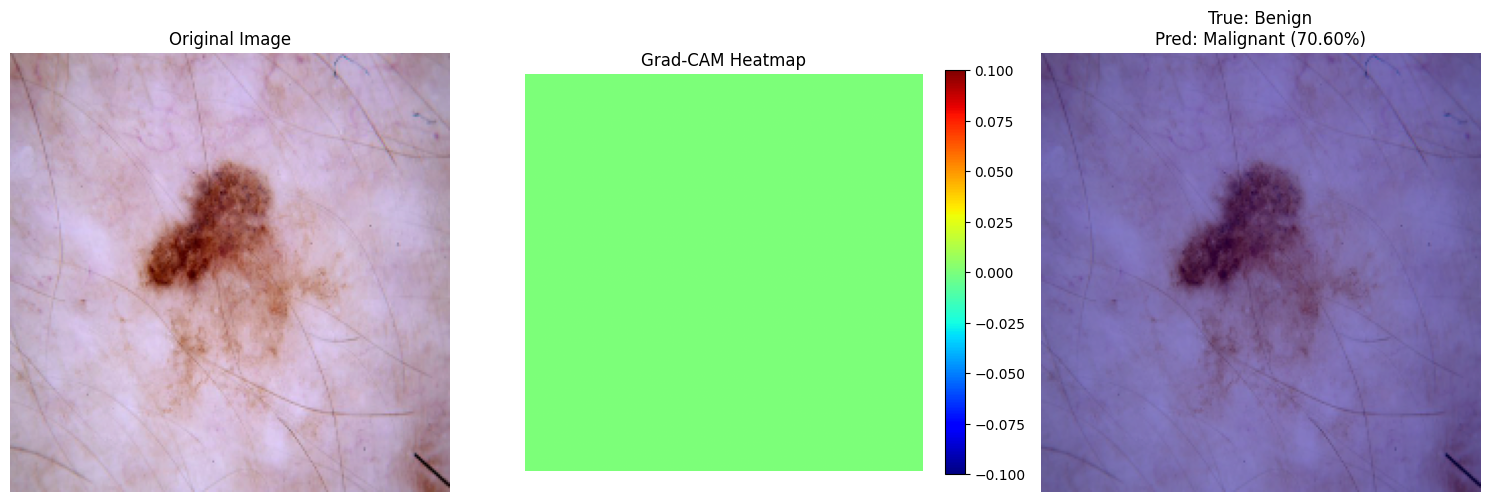

In [40]:
run_gradcam()
